In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
face_cascade = cv2.CascadeClassifier('C:\\haarcascades\\haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('C:\\haarcascades\\haarcascade_eye.xml')

In [3]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

In [4]:
path_to_data = "C:\\Users\\sherl\\Downloads\\Image_Classification\\Model\\Dataset\\"
path_to_cr_data = "C:\\Users\\sherl\\Downloads\\Image_Classification\\Model\\Dataset\\cropped\\"

In [13]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [14]:
img_dirs

['C:\\Users\\sherl\\Downloads\\Image_Classification\\Model\\Dataset\\Dwayne_Johnson',
 'C:\\Users\\sherl\\Downloads\\Image_Classification\\Model\\Dataset\\Leonardo_Dicaprio',
 'C:\\Users\\sherl\\Downloads\\Image_Classification\\Model\\Dataset\\Natalie_Portman',
 'C:\\Users\\sherl\\Downloads\\Image_Classification\\Model\\Dataset\\Virat_Kohli']

In [15]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)


In [16]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('\\')[-1]
    print(celebrity_name)
    
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "\\" + cropped_file_name 
            
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1 

Dwayne_Johnson
Generating cropped images in folder:  C:\Users\sherl\Downloads\Image_Classification\Model\Dataset\cropped\Dwayne_Johnson
Leonardo_Dicaprio
Generating cropped images in folder:  C:\Users\sherl\Downloads\Image_Classification\Model\Dataset\cropped\Leonardo_Dicaprio
Natalie_Portman
Generating cropped images in folder:  C:\Users\sherl\Downloads\Image_Classification\Model\Dataset\cropped\Natalie_Portman
Virat_Kohli
Generating cropped images in folder:  C:\Users\sherl\Downloads\Image_Classification\Model\Dataset\cropped\Virat_Kohli


In [17]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img

    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )

    imArray =  np.float32(imArray)   
    imArray /= 255;

    coeffs=pywt.wavedec2(imArray, mode, level=level)

    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [18]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'Dwayne_Johnson': 0,
 'Leonardo_Dicaprio': 1,
 'Natalie_Portman': 2,
 'Virat_Kohli': 3}

In [19]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])  

In [20]:
len(X[0])

4096

In [21]:
X=np.array(X).reshape(len(X),4096).astype(float)
X.shape

(179, 4096)

In [22]:
X[0]

array([ 55.,  28.,  18., ...,  21.,  15., 236.])

In [29]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)


0.8

In [26]:
print(classification_report(y_test,pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.75      0.43      0.55         7
           1       0.68      1.00      0.81        17
           2       1.00      0.77      0.87        13
           3       1.00      0.75      0.86         8

    accuracy                           0.80        45
   macro avg       0.86      0.74      0.77        45
weighted avg       0.84      0.80      0.79        45



In [30]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [31]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [33]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.820513,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.678632,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.761254,{'logisticregression__C': 1}


In [34]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [35]:
best_estimators['svm'].score(X_test,y_test)

0.9111111111111111

In [36]:
best_estimators['random_forest'].score(X_test,y_test)

0.6

In [37]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8666666666666667

In [38]:
best_clf = best_estimators['svm']

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm


array([[ 4,  3,  0,  0],
       [ 0, 17,  0,  0],
       [ 0,  1, 12,  0],
       [ 0,  0,  0,  8]], dtype=int64)

Text(69.0, 0.5, 'Truth')

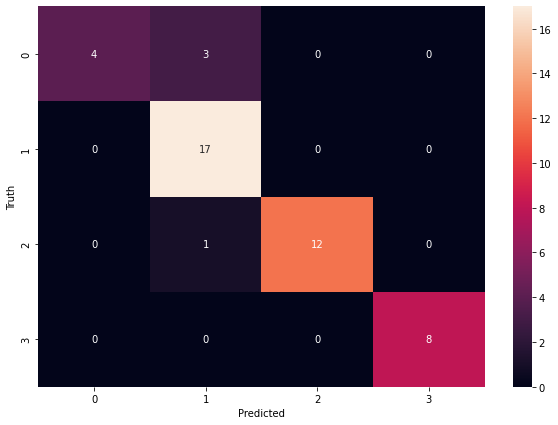

In [40]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [41]:
class_dict

{'Dwayne_Johnson': 0,
 'Leonardo_Dicaprio': 1,
 'Natalie_Portman': 2,
 'Virat_Kohli': 3}

In [42]:
import joblib
joblib.dump(best_clf,'saved_model.pkl')

['saved_model.pkl']

In [43]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))